In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import h5py
from scipy import optimize, stats

In [16]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 5
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 5
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
# plt.rc("text", usetex=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18)



COLORS = ["f07167","219ebc","c767ac","ffba0a","59a270"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Load catalog

In [4]:
psf_cat_inds = np.load('/scratch/midway3/dhayaa/SHEARTESTS/DR3_hyperparam/psf_inds.npy')

with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecat_20231216.hdf5', 'r') as f:
        
    x, y = f['focal_x'][:][psf_cat_inds], f['focal_y'][:][psf_cat_inds]
    g1_star  = f['g1_star_hsm'][:][psf_cat_inds]
    g2_star  = f['g2_star_hsm'][:][psf_cat_inds]
    g1_model = f['g1_model_hsm'][:][psf_cat_inds]
    g2_model = f['g2_model_hsm'][:][psf_cat_inds]

    w  = (f['T_star_hsm'][:][psf_cat_inds] - f['T_model_hsm'][:][psf_cat_inds])/f['T_star_hsm'][:][psf_cat_inds]
    w1 = g1_star * w
    w2 = g2_star * w

    q1 = g1_star - g1_model
    q2 = g2_star - g2_model

    del g1_star, g2_star

    band = np.array(f['BAND'][:]).astype('U1')[psf_cat_inds]
    SNR  = f['FLUX_AUTO'][:][psf_cat_inds]/f['FLUXERR_AUTO'][:][psf_cat_inds]

    No_Gband  = band != 'g' #We don't use g-band in shear
    SNR_Mask  = SNR > 80

    print(np.sum(No_Gband), np.sum(SNR_Mask))
    Mask = SNR_Mask & No_Gband
    
    del SNR_Mask, No_Gband, SNR, band

    print("TOTAL NUM", np.sum(Mask))
    x  = x[Mask]
    y  = y[Mask]
    w  = w[Mask]
    g1_model = g1_model[Mask]
    g2_model = g2_model[Mask]
    q1  = q1[Mask]
    q2  = q2[Mask]
    w1  = w1[Mask]
    w2  = w2[Mask]

159653448 76846018
TOTAL NUM 59869596


# Make maps

In [5]:
Nbins = 1000
binrange = (2048, 2048 * 13), (0, 4096 * 7)
counts = np.histogram2d(x, y, bins = Nbins, range = binrange)[0]
p1_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = g1_model)[0]/counts
p2_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = g2_model)[0]/counts
q1_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = q1)[0]/counts
q2_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = q2)[0]/counts
w_map  = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = w)[0]/counts
w1_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = w1)[0]/counts
w2_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = w2)[0]/counts

/scratch/local/jobs/20112741/ipykernel_4016763/2076974977.py:4: RuntimeWarning: invalid value encountered in divide
  p1_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = g1_model)[0]/counts
/scratch/local/jobs/20112741/ipykernel_4016763/2076974977.py:5: RuntimeWarning: invalid value encountered in divide
  p2_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = g2_model)[0]/counts
/scratch/local/jobs/20112741/ipykernel_4016763/2076974977.py:6: RuntimeWarning: invalid value encountered in divide
  q1_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = q1)[0]/counts
/scratch/local/jobs/20112741/ipykernel_4016763/2076974977.py:7: RuntimeWarning: invalid value encountered in divide
  q2_map = np.histogram2d(x, y, bins = Nbins, range = binrange, weights = q2)[0]/counts
/scratch/local/jobs/20112741/ipykernel_4016763/2076974977.py:8: RuntimeWarning: invalid value encountered in divide
  w_map  = np.histogram2d(x, y, bins = Nbins, range = bi

# Plot

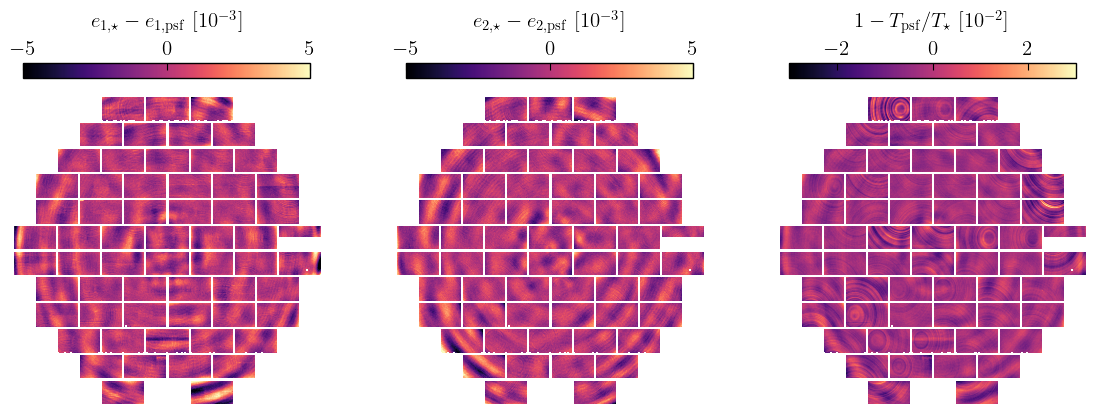

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (14, 5),)
plt.subplots_adjust(hspace = 0.00)

labels = ['$e_{1, \star} - e_{1, \\rm psf}$  [$10^{-3}$]', 
          '$e_{2, \star} - e_{2, \\rm psf}$  [$10^{-3}$]', 
          '$1 - T_{\\rm psf}/T_\star$  [$10^{-2}$]']

# labels = ["test","test", "test"]


for i, m, l in zip(range(3), [q1_map * 1e3, q2_map * 1e3, w_map * 1e2], labels):
    
    lim = 3 if i == 2 else 5
    im = ax[i].imshow(m, cmap = 'magma', vmin  = -lim, vmax = lim)
    c = plt.colorbar(im, ax = ax[i], location = 'top',  orientation = 'horizontal', shrink = 0.9)
    c.set_label(l, size = 15, color = 'k', labelpad = 10)
    for t in c.ax.get_xticklabels():
         t.set_fontsize(15)

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    for spine in ax[i].spines.values(): spine.set_visible(False)
        
plt.savefig('./psf_focalplane.pdf', dpi = 300, bbox_inches = 'tight')